#### I. Paquetes específicos probados

# Numerical development to resolve Time-Dependent Schrödinger equation through eigenvalue problem

## 1. Import modules with useful functions, parameters, and algorithms.

In [1]:
println("Number of threads = ", Threads.nthreads());

Number of threads = 4


In [2]:
name_code = "03_Code_auxiliary_tests";

In [4]:
# If we have problems with gridap_makie folder probably running the next command we resolve that
Pkg.resolve()
Pkg.instantiate()

  No Changes to `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie/Project.toml`
  No Changes to `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie/Manifest.toml`


In [188]:
include("../modules/module_schrodinger_equation_eigenproblem.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie`


## 2. Resolve the 2D problem

### 2.1. Resolve 2D eigenvalue problem

Define mesh properties and create the mesh

In [15]:
dom_2D=(-12.0*Angstrom_to_au,12.0*Angstrom_to_au,-4.9*Angstrom_to_au*γ,4.9*Angstrom_to_au*γ);   # cantidad de FE y dominio espacial
n_1D_r=70;n_1D_R=29;    # cantidad de FE por dimension (cantidad de intervalos)
ΔrH=abs(dom_2D[2]-dom_2D[1])*(1.0/n_1D_r); ΔRH=abs(dom_2D[4]-dom_2D[3])*(1.0/n_1D_R)                        # tamaño del elemento 2D
partition_2D=(n_1D_r,n_1D_R);                               # grilla de tamaño n²
model_2D=CartesianDiscreteModel(dom_2D,partition_2D);   # creamos modelo con elementos cartesianos
println("ΔrH=$(round(ΔrH/Angstrom_to_au,digits=2))[Å]; ΔRH=$(round(ΔRH/Angstrom_to_au,digits=2))[Å]; ΔχH=$(round(ΔRH/(Angstrom_to_au*γ),digits=2))[Å]")
println("n_1D_r*n_1D_R=$(n_1D_r*n_1D_R) FE")

ΔrH=0.34[Å]; ΔRH=15.11[Å]; ΔχH=0.34[Å]
n_1D_r*n_1D_R=2030 FE


In [14]:
writevtk(model_2D,path_models*"CartesianDiscreteModel");

In [16]:
DOF_r,DOF_R,pts=space_coord_2D(dom_2D,ΔrH,ΔRH);

define boundary conditions

In [17]:
dirichlet_values_2D=(0.0+im*0.0);        # condiciones de contorno de tipo fulldirichlet
dirichlet_tags_2D="boundary";

In [18]:
Ω_2D,dΩ_2D,Γ_2D,dΓ_2D=measures(model_2D,3,dirichlet_tags_2D);
reffe_2D=ReferenceFE(lagrangian,Float64,2);

Define bilinear forms and FE spaces

In [105]:
VH_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
UH_2D=TrialFESpace(VH_2D,dirichlet_values_2D);

R₁=-5.0*Angstrom_to_au;R₂=5.0*Angstrom_to_au;Rf=1.5*Angstrom_to_au;
β=3.57*(1.0/(Angstrom_to_au*Angstrom_to_au));

set_Rc_value=2; # set_Rc_value=1 or set_Rc_value=2
if (set_Rc_value==1)
    Rc=1.5*Angstrom_to_au;  # screening parameter
    χ₀=-3.5*Angstrom_to_au; # Gaussian's center of init state
    n_eigenstate=1;         # fundamental state
elseif (set_Rc_value==2) 
    Rc=5.0*Angstrom_to_au;
    χ₀=-1.5*Angstrom_to_au;
    n_eigenstate=2;  # first excited state
end

pH_2D,qH_2D,rH_2D=eigenvalue_problem_functions((R₁,R₂,Rc,Rf);switch_potential = "Electron_Nuclear_Potential_2D")
aH_2D,bH_2D=bilineal_forms(pH_2D,qH_2D,rH_2D,dΩ_2D);

Set Electron-Nuclear potential


Solve eigenvalue problem

In [106]:
nevH=500;
probH_2D=EigenProblem(aH_2D,bH_2D,UH_2D,VH_2D;nev=nevH,tol=10^(-9),maxiter=1000,explicittransform=:none,sigma=-10.0);

In [107]:
ϵH_2D,ϕH_2D=solve(probH_2D);

Exportamos el potencial de interacción y superficies de potencial

In [161]:
for i in 1:10#nevH
    writevtk(Ω_2D,path_images*"potential_energy_surface_2D$(set_Rc_value)_num$(i)",cellfields=["ϵH_2D" => real(ϵH_2D[i])]);
end

In [162]:
qH_2D_InterpolationGridap=CellField(x->qH_2D(x),Ω_2D);
writevtk(Ω_2D,path_images*"interaction_potential_2D",cellfields=["qH_2D" => qH_2D_InterpolationGridap]);

Chequeamos ortogonalidad de los autoestados

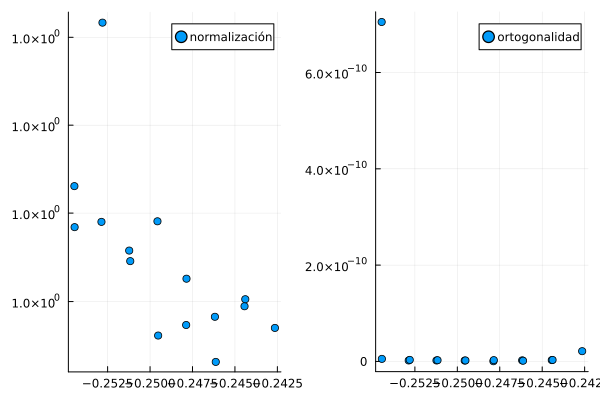

GKS: Possible loss of precision in routine SET_WINDOW


In [11]:
plot1=scatter(real(ϵH_2D),normalization_eigenstates(ϕH_2D,UH_2D,dΩ_2D),label="normalización")
plot2=scatter(real(ϵH_2D),OrthoCheck_v2(ϕH_2D,UH_2D,dΩ_2D),label="ortogonalidad")

display(plot(plot1,plot2,layout=2))

In [163]:
# Escribimos autovectores para visualizar externamente
write_data=true;
if write_data
    for i in 1:10#nevH
        writevtk(Ω_2D,path_images*"eigenprob_2D_Rcvalue$(set_Rc_value)_num$(i)",cellfields=["ρ_eigenstates" => real((ϕH_2D[i]')*ϕH_2D[i])]);
    end
end

-------------------------

## Creamos grilla 2D con la coordenada nuclear original e interpolamos los autoestados en esta nueva grilla

In [108]:
dom_2D_χ=(dom_2D[1],dom_2D[2],dom_2D[3]/γ,dom_2D[4]/γ);   # cantidad de FE y dominio espacial
ΔχH=ΔRH/γ;
model_2D_χ=CartesianDiscreteModel(dom_2D_χ,partition_2D);   # creamos modelo con elementos cartesianos

Ω_2D_χ,dΩ_2D_χ,Γ_2D_χ,dΓ_2D_χ=measures(model_2D_χ,3,dirichlet_tags_2D);

VH_2D_χ=TestFESpace(model_2D_χ,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
UH_2D_χ=TrialFESpace(VH_2D_χ,dirichlet_values_2D);

In [109]:
DOF_r,DOF_χ,pts_χ=space_coord_2D(dom_2D_χ,ΔrH,ΔχH);

In [110]:
nevHχ=500 # debe cumplirse que nevHχ ≤ nevH
ϕH_2D_χ=Vector{CellField}(undef,nevHχ);
for i in 1:nevHχ
    ϕHR_2Dₓᵢ=Interpolable(CellField(x->ϕH_2D[i](Point(x[1],x[2]*γ)),Ω_2D)); # le decimos que sea un objeto interpolable
    ϕH_2D_χ[i]=interpolate_everywhere(ϕHR_2Dₓᵢ,UH_2D_χ);                    # interpolamos en el nuevo domino
    ϕH_2D_χ[i]=interpolate_everywhere(ϕH_2D_χ[i]*sqrt(γ),UH_2D_χ);          # normalizamos los nuevos autoestados
end

In [111]:
ϵH_2D_χ=ϵH_2D[1:nevHχ];

In [18]:
write_data=true
if write_data
    for i in 1:10#nevH      
        writevtk(Ω_2D_χ,path_images*"eigenprob_domrχ_2D_Rcvalue$(set_Rc_value)_num$(i)",cellfields=["ρrχ_eigenstates" => real((ϕH_2D_χ[i])'*ϕH_2D_χ[i])]);
    end
end

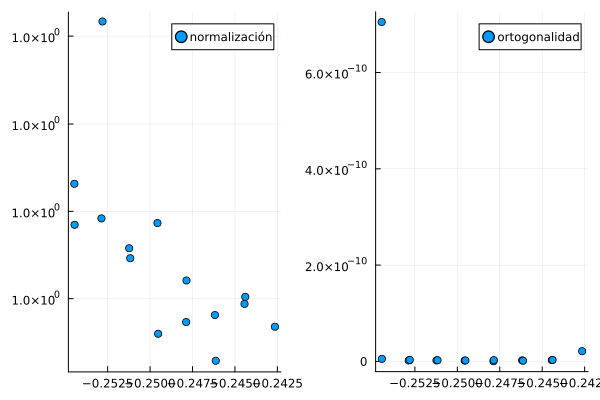

In [14]:
plot1=scatter(real(ϵH_2D_χ),normalization_eigenstates(ϕH_2D_χ,UH_2D_χ,dΩ_2D_χ),label="normalización")
plot2=scatter(real(ϵH_2D_χ),OrthoCheck_v2(ϕH_2D_χ,UH_2D_χ,dΩ_2D_χ),label="ortogonalidad")

display(plot(plot1,plot2,layout=2))

---------------------------------------

## Creamos la grilla 1D para resolver el problema electrónico

Acá creamos espacios unidimensionales para el grado de libertad electrónico y nuclear. Ambos espacios serán útiles para integrar las densidades de probabilidad electrónicas y nucleares y obtener las entropías, además el espacio electronico será ùtil para encontrar los autoestados electrónicos parametrizados para una coordenada nuclear.

In [112]:
grid_type="simple_line";                            # tipo de grilla

ΔrH_1D=ΔrH;                             # tamaño del elento 1D
ΔχH_1D=ΔRH/γ;

dom_1D_r=(dom_2D[1],dom_2D[2]);
dom_1D_χ=(dom_2D[3]./γ,dom_2D[4]./γ)

par_1D_r=(path_models,grid_type*"_01_r",dom_1D_r,ΔrH_1D);    # (path,name,dom,MeshSize)
par_1D_χ=(path_models,grid_type*"_01_χ",dom_1D_χ,ΔχH_1D);

model_1D_r=make_model(grid_type,par_1D_r);              # creamos modelo
model_1D_χ=make_model(grid_type,par_1D_χ);

# condiciones de contorno de tipo full dirichlet
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[0.0+im*0.0,0.0+im*0.0];

Ω_1D_r,dΩ_1D_r,Γ_1D_r,dΓ_1D_r=measures(model_1D_r,3,dirichlet_tags_1D);
Ω_1D_χ,dΩ_1D_χ,Γ_1D_χ,dΓ_1D_χ=measures(model_1D_χ,3,dirichlet_tags_1D);

reffe_1D=reference_FEspaces(lagrangian,Float64,2);

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000589503s, CPU 0.000221s)
Info    : 71 nodes 72 elements
Info    : Writing '../outputs/03_Code_auxiliary_tests/models/simple_line_01_r.msh'...
Info    : Done writing '../outputs/03_Code_auxiliary_tests/models/simple_line_01_r.msh'
Info    : Reading '../outputs/03_Code_auxiliary_tests/models/simple_line_01_r.msh'...
Info    : 3 entities
Info    : 71 nodes
Info    : 72 elements
Info    : Done reading '../outputs/03_Code_auxiliary_tests/models/simple_line_01_r.msh'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000115959s, CPU 0.000116s)
Info    : 30 nodes 31 elements
Info    : Writing '../outputs/03_Code_auxiliary_tests/models/simple_line_01_χ.msh'...
Info    : Done writing '../outputs/03_Code_auxiliary_tests/models/simple_line_01_χ.msh'
Info    : Reading '../outputs/03_Code_auxiliary_tests/models/simple_line_01_χ.msh'...
Info    : 3 entities
Info    : 3

In [113]:
DOF_r_1D,pts_1D_r=space_coord_1D(dom_1D_r,ΔrH_1D);
DOF_χ_1D,pts_1D_χ=space_coord_1D(dom_1D_χ,ΔχH_1D);

In [114]:
VH_1D_r=TestFESpace(model_1D_r,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
VH_1D_χ=TestFESpace(model_1D_χ,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);

UH_1D_r=TrialFESpace(VH_1D_r,dirichlet_values_1D);
UH_1D_χ=TrialFESpace(VH_1D_χ,dirichlet_values_1D);

In [115]:
pH_1D_χ₀,qH_1D_χ₀,rH_1D_χ₀=eigenvalue_problem_functions((χ₀,R₁,R₂,Rc,Rf);switch_potential = "Electron_Nuclear_Potential_1D")
aH_1D_χ₀,bH_1D_χ₀=bilineal_forms(pH_1D_χ₀,qH_1D_χ₀,rH_1D_χ₀,dΩ_1D_r);

In [116]:
nevH_1D_χ₀=4;
probH_1D_χ₀=EigenProblem(aH_1D_χ₀,bH_1D_χ₀,UH_1D_r,VH_1D_r;nev=nevH_1D_χ₀,tol=10^(-9),maxiter=1000,explicittransform=:none,sigma=-10.0);
ϵH_1D_χ₀,ϕH_1D_χ₀=solve(probH_1D_χ₀);

Esta es otra forma de hacerlo, interpolar el autoestado específico, sin embargo, arroja los mismos resultados que trabajando con los autoestados sin interpolar.

In [ ]:
ϕH_1D_χ₀_Interpolated=InterpolationFunction_v2(ϕH_1D_χ₀[n_eigenstate].(pts_1D_r),DOF_r_1D);

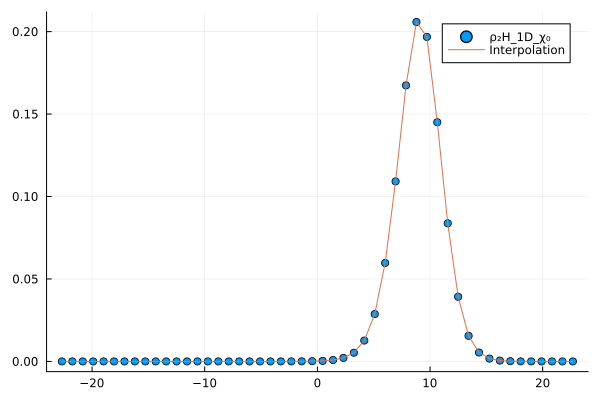

In [ ]:
scatter(DOF_r_1D,real(conj.(ϕH_1D_χ₀[2].(pts_1D_r)).*(ϕH_1D_χ₀[2].(pts_1D_r))),label="ρ₂H_1D_χ₀")
plot!(DOF_r_1D,real(conj.(ϕH_1D_χ₀_Interpolated.(DOF_r_1D)).*(ϕH_1D_χ₀_Interpolated.(DOF_r_1D))),label="Interpolation")

----------------------------------

### Calculamos entropías para cada valor de energía posible

In [47]:
S_2D=TimeIndependet_Diff_Shannon_Entropy(ϕH_2D,UH_2D,dΩ_2D); # domino D={r,R}

In [39]:
S_2D_χ=TimeIndependet_Diff_Shannon_Entropy(ϕH_2D_χ,UH_2D_χ,dΩ_2D_χ); # domino D={r,χ}

### 5.2. Resolve time-dependent Schrödinger equation

#### 5.2.1. Create initial condition

In [117]:
# función compactada para organizar mejor el código
function create_initial_state_2D(params;TypeOfFunction="FunctionScalingVariable")
    if TypeOfFunction=="FunctionScalingVariable"
        χ₀,β,ϕₙᵢ,Ω,dΩ = params;
        𝛹ₓ₀ = CellField(x->exp(-β*pow((x[2]*(1.0/γ)-χ₀),2)),Ω)*ϕₙᵢ;
        𝛹ₓ₀ = 𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    elseif TypeOfFunction=="OriginalFunction"
        χ₀,β,ϕₙᵢ,Ω,dΩ = params;
        𝛹ₓ₀ = CellField(x->exp(-β*pow((x[2]-χ₀),2)),Ω)*ϕₙᵢ;
        𝛹ₓ₀ = 𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    elseif TypeOfFunction=="OriginalFunctionBOAprox_v1"
        χ₀,β,ϕₙᵢ,Ω,dΩ = params;
        𝛹ₓ₀ = CellField(x->exp(-β*pow((x[2]-χ₀),2))*ϕₙᵢ(Point(x[1],χ₀)),Ω);
        𝛹ₓ₀ = 𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    elseif TypeOfFunction=="OriginalFunctionBOAprox_v2"
        χ₀,β,ϕₙᵢ,Ω,dΩ,TrialSpace = params;
        𝛹ₓ₀Gridap = CellField(x->exp(-β*pow((x[2]-χ₀),2))*ϕₙᵢ(Point(x[1],χ₀)),Ω);
        𝛹ₓ₀ = interpolate_everywhere(𝛹ₓ₀Gridap,TrialSpace);
        𝛹ₓ₀ = 𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    elseif TypeOfFunction=="OriginalFunctionBOAprox_v3"
        χ₀,β,ϕₙᵢInterpolated,Ω,dΩ,TrialSpace = params;
        𝛹ₓ₀Gridap = CellField(x->exp(-β*pow((x[2]-χ₀),2))*ϕₙᵢInterpolated(x[1]),Ω);
        𝛹ₓ₀ = interpolate_everywhere(𝛹ₓ₀Gridap,TrialSpace);
        𝛹ₓ₀ = 𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    elseif TypeOfFunction=="OriginalFunctionBOAprox_v4"
        χ₀,β,ϕₙᵢ,Ω,dΩ,TrialSpace = params;
        𝛹ₓ₀Gridap = CellField(x->exp(-β*pow((x[2]-χ₀),2))*ϕₙᵢ(Point(x[1])),Ω);
        𝛹ₓ₀ = interpolate_everywhere(𝛹ₓ₀Gridap,TrialSpace);
        𝛹ₓ₀ = 𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    end
    return 𝛹ₓ₀;
end

create_initial_state_2D (generic function with 1 method)

In [52]:
# domino D={r,R}
𝛹ₓ₀=create_initial_state_2D((χ₀,β,ϕH_2D[n_eigenstate],Ω_2D,dΩ_2D);TypeOfFunction="FunctionScalingVariable");

In [118]:
# domino D={r,χ}
# 𝛹ₓ₀_χ=create_initial_state_2D((χ₀,β,ϕH_2D[n_eigenstate],Ω_2D_χ,dΩ_2D_χ);TypeOfFunction="OriginalFunction");
# 𝛹ₓ₀_χ=create_initial_state_2D((χ₀,β,ϕH_2D[n_eigenstate],Ω_2D_χ,dΩ_2D_χ);TypeOfFunction="OriginalFunctionBOAprox_v1");
# 𝛹ₓ₀_χ=create_initial_state_2D((χ₀,β,ϕH_2D[n_eigenstate],Ω_2D_χ,dΩ_2D_χ,UH_2D_χ);TypeOfFunction="OriginalFunctionBOAprox_v2");
# 𝛹ₓ₀_χ=create_initial_state_2D((χ₀,β,ϕH_1D_χ₀_Interpolated,Ω_2D_χ,dΩ_2D_χ,UH_2D_χ);TypeOfFunction="OriginalFunctionBOAprox_v3");
𝛹ₓ₀_χ=create_initial_state_2D((χ₀,β,ϕH_1D_χ₀[n_eigenstate],Ω_2D_χ,dΩ_2D_χ,UH_2D_χ);TypeOfFunction="OriginalFunctionBOAprox_v4");

In [38]:
writevtk(Ω_2D,path_images*"initial_condition_Rcvalue$(set_Rc_value)",cellfields=["ρₓ₀" => real((𝛹ₓ₀)'*𝛹ₓ₀)]);

In [119]:
writevtk(Ω_2D_χ,path_images*"initial_condition__domrχRcvalue$(set_Rc_value)",cellfields=["ρₓ₀" => real((𝛹ₓ₀_χ)'*𝛹ₓ₀_χ)]);

Chequeamos convergencia para el método de evolución temporal, la idea acá es computar los coeficientes de descomposición lineal del estado inicial en los autoestados del hamiltoniano.

Teniendo en cuenta que

\begin{array}{l}
    \ket{\psi ^{( n)}( t=0)} =\sum _{j=1}^{n} c_{j}\ket{\phi _{j}} \Rightarrow \ket{\psi ^{( n)}( t)} =\sum _{j=1}^{n} c_{j}\exp\left( -\frac{i}{\hbar } \epsilon _{j} t\right)\ket{\phi _{j}} ;\ \bra{\phi _{i}}\ket{\phi _{j}} =\delta _{ij}\\
    \bra{\psi ^{( n)}( t)}\ket{\psi ^{( n+q)}( t)} =\left[\sum _{j=1}^{n}( c_{j})^{*}\exp\left(\frac{i}{\hbar } \epsilon _{j} t\right)\bra{\phi _{j}}\right]\left[\sum _{k=1}^{( n+q)} c_{k}\exp\left( -\frac{i}{\hbar } \epsilon _{k} t\right)\ket{\phi _{k}}\right] = \sum _{j=1}^{n}( c_{j})^{*} c_{j}\stackrel{?}{=} 1
\end{array}

Entonces, ploteamos qué tanto se separa esta sumatoria del valor de la unidad.

In [53]:
CheckConvergenceVector=CheckConvergence(𝛹ₓ₀,ϕH_2D,UH_2D,dΩ_2D); # domino D={r,R}
println("$(CheckConvergenceVector[end])")

0.990266420777022


In [120]:
CheckConvergenceVector_χ=CheckConvergence(𝛹ₓ₀_χ,ϕH_2D_χ,UH_2D_χ,dΩ_2D_χ); # domino D={r,χ}
println("$(CheckConvergenceVector_χ[end])")

0.9999999993676557


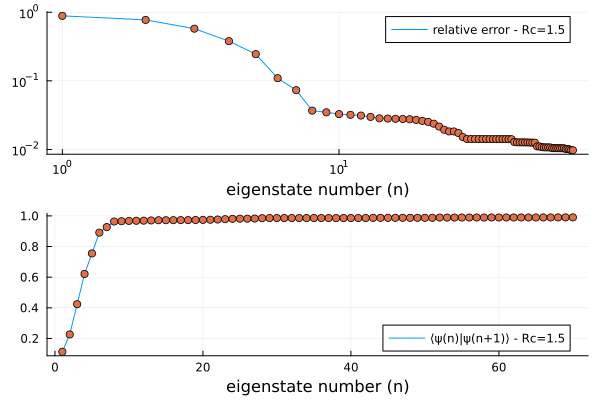

In [54]:
plot1=plot()
plot2=plot!(plot1,abs.(1.0 .- CheckConvergenceVector) ./ 1.0,label="relative error - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot2=scatter!(plot1,abs.(1.0 .- CheckConvergenceVector) ./ 1.0,label="")
plot2=plot!(xlabel="eigenstate number (n)",ylabel="",yaxis=:log,xaxis=:log)

plot3=plot()
plot4=plot!(plot3,CheckConvergenceVector,label="⟨ψ(n)|ψ(n+1)⟩ - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot4=scatter!(plot3,CheckConvergenceVector,label="")
plot4=plot!(xlabel="eigenstate number (n)",ylabel="")

display(plot(plot2,plot4,layout=(2,1)))

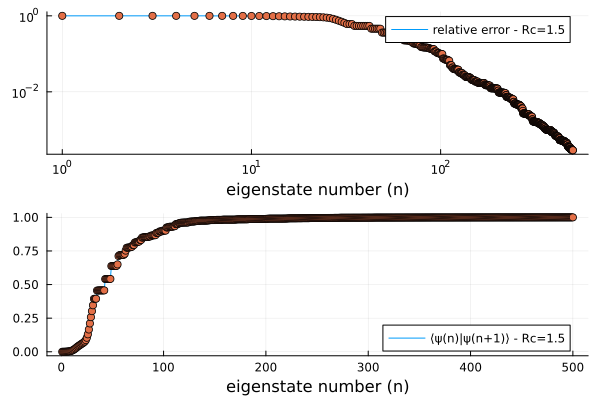

In [52]:
plot1=plot()
plot2=plot!(plot1,abs.(1.0 .- CheckConvergenceVector_χ) ./ 1.0,label="relative error - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot2=scatter!(plot1,abs.(1.0 .- CheckConvergenceVector_χ) ./ 1.0,label="")
plot2=plot!(xlabel="eigenstate number (n)",ylabel="",yaxis=:log,xaxis=:log)

plot3=plot()
plot4=plot!(plot3,CheckConvergenceVector_χ,label="⟨ψ(n)|ψ(n+1)⟩ - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot4=scatter!(plot3,CheckConvergenceVector_χ,label="")
plot4=plot!(xlabel="eigenstate number (n)",ylabel="")

display(plot(plot2,plot4,layout=(2,1)))

In [ ]:
plot1=plot()
plot2=plot!(plot1,abs.(1.0 .- CheckConvergenceVector) ./ 1.0,label="relative error - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot2=scatter!(plot1,abs.(1.0 .- CheckConvergenceVector) ./ 1.0,label="")
plot2=plot!(xlabel="eigenstate number (n)",ylabel="",yaxis=:log,xaxis=:log)

plot3=plot()
plot4=plot!(plot3,CheckConvergenceVector,label="⟨ψ(n)|ψ(n+1)⟩ - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot4=scatter!(plot3,CheckConvergenceVector,label="")
plot4=plot!(xlabel="eigenstate number (n)",ylabel="")

display(plot(plot2,plot4,layout=(2,1)))

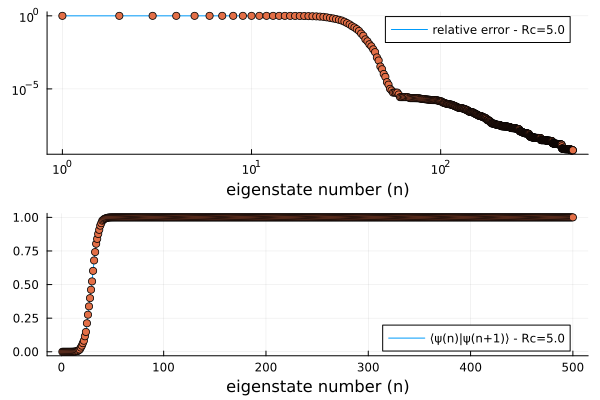

In [121]:
plot1=plot()
plot2=plot!(plot1,abs.(1.0 .- CheckConvergenceVector_χ) ./ 1.0,label="relative error - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot2=scatter!(plot1,abs.(1.0 .- CheckConvergenceVector_χ) ./ 1.0,label="")
plot2=plot!(xlabel="eigenstate number (n)",ylabel="",yaxis=:log,xaxis=:log)

plot3=plot()
plot4=plot!(plot3,CheckConvergenceVector_χ,label="⟨ψ(n)|ψ(n+1)⟩ - Rc=$(round(Rc/Angstrom_to_au;digits=2))")
plot4=scatter!(plot3,CheckConvergenceVector_χ,label="")
plot4=plot!(xlabel="eigenstate number (n)",ylabel="")

display(plot(plot2,plot4,layout=(2,1)))

#### 5.2.2. Time evolution

In [122]:
t_start=0.0;t_end=200*Femtoseconds_to_au;           # tiempos adimensionales inicial y final
Δt=100.0; # time step
n_points=round(Int,abs(t_end-t_start)*(1.0/Δt))+1;  # number of dicrete time points

# total number of the wave function value to be saved in vtk format
t_end_vtk=10*Femtoseconds_to_au; # ¿hasta qué tiempo final quiero escribir datos?
n_save_vtk=round(Int,abs(t_end_vtk-t_start)*(1.0/Δt))+1; # calculo de la cantidad de puntos a escribir

time_vec=[t_start+Δt*(i-1) for i in 1:n_points];

println("Δt=$(Δt/Femtoseconds_to_au)[fs]; dim(time_vec)=$(length(time_vec))");
println("Escribimos $(n_save_vtk) datos hasta un tiempo final de $(t_end_vtk/Femtoseconds_to_au) [fs]")

Δt=2.18884[fs]; dim(time_vec)=92
Escribimos 6 datos hasta un tiempo final de 10.0 [fs]


In [ ]:
𝛹ₓₜ=evolution_schrodinger_v2(𝛹ₓ₀,ϕH_2D,ϵH_2D,UH_2D,dΩ_2D,time_vec); # domino D={r,R}

In [79]:
index_dat=0
for i in 1:20:n_points
    index_dat+=1
    writevtk(Ω_2D,path_images*"evolution_wave_function_Rcvalue$(set_Rc_value)_$(lpad(index_dat,3,'0'))",cellfields=["ρₓₜ" => real((𝛹ₓₜ[i])'*𝛹ₓₜ[i])]);
end

In [123]:
𝛹ₓₜ_χ=evolution_schrodinger_v2(𝛹ₓ₀_χ,ϕH_2D_χ,ϵH_2D_χ,UH_2D_χ,dΩ_2D_χ,time_vec); # domino D={r,χ}

In [182]:
index_dat=0
for i in 1:20:n_points
    index_dat+=1
    writevtk(Ω_2D_χ,path_images*"evolution_wave_function_domrχ_Rcvalue$(set_Rc_value)_$(lpad(index_dat,3,'0'))",cellfields=["ρₓₜ" => real((𝛹ₓₜ_χ[i])'*𝛹ₓₜ_χ[i])]);
end

### 5.3. Calculate entropy

In [57]:
function Partial_probability_density(𝛹ₓ_vector,x₁_vector,x₂_vector,TrialSpace,Ω,dΩ;TypeAproxDeltaFunction="StepFunction",Improved=false)

    ρ_x₁_matrix=zeros(Float64,length(x₁_vector),length(𝛹ₓ_vector));
    ρ_x₂_matrix=zeros(Float64,length(x₂_vector),length(𝛹ₓ_vector));

    N₁=abs(x₁_vector[end]-x₁_vector[1]);
    N₂=abs(x₂_vector[end]-x₂_vector[1]);

    if (TypeAproxDeltaFunction=="StepFunction")
        Δx₁=abs(x₁_vector[2]-x₁_vector[1]);
        Δx₂=abs(x₂_vector[2]-x₂_vector[1]);
    end

    for t_index in 1:length(𝛹ₓ_vector)
        𝛹ₓᵢ=interpolate_everywhere(𝛹ₓ_vector[t_index],TrialSpace);
        𝛹ₓᵢ=𝛹ₓᵢ/norm_L2(𝛹ₓᵢ,dΩ);
        ρₓᵢ=real(𝛹ₓᵢ'*𝛹ₓᵢ);

        for x₁_index in 1:length(x₁_vector)
            if (TypeAproxDeltaFunction=="StepFunction")
                params=(x₁_vector[x₁_index],1.0,1,Δx₁)
            elseif (TypeAproxDeltaFunction=="BumpFunction")
                params=(x₁_vector[x₁_index],1.0,1)
            end
            δKroneckerGridap=CellField(x->AproxDiracDeltaFunction(x,params;TypeFunction=TypeAproxDeltaFunction),Ω);
            δnorm=sum(integrate(δKroneckerGridap,dΩ));
            if (TypeAproxDeltaFunction=="StepFunction")
                params=(x₁_vector[x₁_index],δnorm/N₂,1,Δx₁)
            elseif (TypeAproxDeltaFunction=="BumpFunction")
                params=(x₁_vector[x₁_index],δnorm/N₂,1)
            end
            δKroneckerGridap=CellField(x->AproxDiracDeltaFunction(x,params;TypeFunction=TypeAproxDeltaFunction),Ω);
            Improved==true ? ρ_x₁_matrix[t_index,x₁_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ)) : ρ_x₁_matrix[x₁_index,t_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ))
        end

        for x₂_index in 1:length(x₂_vector)
            if (TypeAproxDeltaFunction=="StepFunction")
                params=(x₂_vector[x₂_index],1.0,2,Δx₂)
            elseif (TypeAproxDeltaFunction=="BumpFunction")
                params=(x₂_vector[x₂_index],1.0,2)
            end
            δKroneckerGridap=CellField(x->AproxDiracDeltaFunction(x,params;TypeFunction=TypeAproxDeltaFunction),Ω);
            δnorm=sum(integrate(δKroneckerGridap,dΩ));
            if (TypeAproxDeltaFunction=="StepFunction")
                params=(x₂_vector[x₂_index],δnorm/N₁,2,Δx₂)
            elseif (TypeAproxDeltaFunction=="BumpFunction")
                params=params=(x₂_vector[x₂_index],δnorm/N₁,2)
            end
            δKroneckerGridap=CellField(x->AproxDiracDeltaFunction(x,params;TypeFunction=TypeAproxDeltaFunction),Ω);
            Improved==true ? ρ_x₂_matrix[t_index,x₂_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ)) : ρ_x₂_matrix[x₂_index,t_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ))
        end
    end
    return ρ_x₁_matrix,ρ_x₂_matrix;
end

Partial_probability_density (generic function with 1 method)

La siguiente función es para calcular las entropías relativas sin uso de las funciones delta, pero es muy costoso computacionalmente y no arroja muy buenos resultados

In [145]:
function probability_density_interpolation(xᵢ,ρᵢⱼ,DOFᵢ,Ωⱼ_1D,TrialSpaceⱼ_1D)
    # (DOFᵢ==1) ? ρⱼ_xᵢGridap=Interpolable(CellField(x->ρᵢⱼ(Point(xᵢ,x[1])),Ωⱼ_1D)) : ρⱼ_xᵢGridap=Interpolable(CellField(x->ρᵢⱼ(Point(x[1],xᵢ)),Ωⱼ_1D))
    (DOFᵢ==1) ? ρⱼ_xᵢGridap=CellField(x->ρᵢⱼ(Point(xᵢ,x[1])),Ωⱼ_1D) : ρⱼ_xᵢGridap=CellField(x->ρᵢⱼ(Point(x[1],xᵢ)),Ωⱼ_1D)
    
    ρⱼxᵢ=interpolate_everywhere(ρⱼ_xᵢGridap,TrialSpaceⱼ_1D)
    return ρⱼxᵢ
end

function Partial_probability_density_v2(𝛹ₓ_vector,x₁_vector,x₂_vector,TrialSpace_2D,dΩ_2D,
    TrialSpace_1D_x₁,Ω_1D_x₁,dΩ_1D_x₁,TrialSpace_1D_x₂,Ω_1D_x₂,dΩ_1D_x₂)
    ρ_x₁_matrix=zeros(Float64,length(x₁_vector),length(𝛹ₓ_vector));
    ρ_x₂_matrix=zeros(Float64,length(x₂_vector),length(𝛹ₓ_vector));

    for t_index in 1:length(𝛹ₓ_vector)
        𝛹ₓᵢ=interpolate_everywhere(𝛹ₓ_vector[t_index],TrialSpace_2D);
        𝛹ₓᵢ=𝛹ₓᵢ/norm_L2(𝛹ₓᵢ,dΩ_2D);
        ρₓᵢ=real(𝛹ₓᵢ'*𝛹ₓᵢ);

        for x₁_index in 1:length(x₁_vector)
            ρ₂_x¹ᵢ=probability_density_interpolation(x₁_vector[x₁_index],ρₓᵢ,1,Ω_1D_x₂,TrialSpace_1D_x₂)
            ρ_x₁_matrix[x₁_index,t_index]=real(sum(integrate(ρ₂_x¹ᵢ,dΩ_1D_x₂)))
        end

        for x₂_index in 1:length(x₂_vector)
            ρ₁_x²ᵢ=probability_density_interpolation(x₂_vector[x₂_index],ρₓᵢ,2,Ω_1D_x₁,TrialSpace_1D_x₁)
            ρ_x₂_matrix[x₂_index,t_index]=real(sum(integrate(ρ₁_x²ᵢ,dΩ_1D_x₁)))
        end
    end

    return ρ_x₁_matrix,ρ_x₂_matrix;
end

Partial_probability_density_v2 (generic function with 1 method)

----------------------------------------

### Creamos las funciones delta de Dirac (aproximadas) en una sección aparte para poder visualizarlas en Visit y verificar si son buenas aproximaciones.

In [ ]:
# Dominio Dom={r,R}
x₁_vector=DOF_r;x₂_vector=DOF_R;
N₁=abs(x₁_vector[end]-x₁_vector[1]);N₂=abs(x₂_vector[end]-x₂_vector[1]);
δKroneckerGridap₁=CellField(x->AproxDiracDeltaFunction(x,(0.0,1.0,1);TypeFunction="BumpFunction"),Ω_2D);
δnorm₁=sum(integrate(δKroneckerGridap₁,dΩ_2D));
δKroneckerGridap₁=CellField(x->AproxDiracDeltaFunction(x,(0.0,δnorm₁/N₂,1);TypeFunction="BumpFunction"),Ω_2D);
δKroneckerGridap₂=CellField(x->AproxDiracDeltaFunction(x,(0.0,1.0,2);TypeFunction="BumpFunction"),Ω_2D);
δnorm₂=sum(integrate(δKroneckerGridap₂,dΩ_2D));
δKroneckerGridap₂=CellField(x->AproxDiracDeltaFunction(x,(0.0,δnorm₂/N₁,2);TypeFunction="BumpFunction"),Ω_2D);
writevtk(Ω_2D,path_images*"DiracDeltaFunction",cellfields=["δx₁" => δKroneckerGridap₁,"δx₂" => δKroneckerGridap₂]);

In [59]:
# Dominio Dom={r,χ}
x₁_vector=DOF_r;x₂_vector=DOF_χ;
N₁=abs(x₁_vector[end]-x₁_vector[1]);N₂=abs(x₂_vector[end]-x₂_vector[1]);
δKroneckerGridap₁=CellField(x->AproxDiracDeltaFunction(x,(0.0,1.0,1);TypeFunction="BumpFunction"),Ω_2D_χ);
δnorm₁=sum(integrate(δKroneckerGridap₁,dΩ_2D_χ));
δKroneckerGridap₁=CellField(x->AproxDiracDeltaFunction(x,(0.0,δnorm₁/N₂,1);TypeFunction="BumpFunction"),Ω_2D_χ);
δKroneckerGridap₂=CellField(x->AproxDiracDeltaFunction(x,(0.0,1.0,2);TypeFunction="BumpFunction"),Ω_2D_χ);
δnorm₂=sum(integrate(δKroneckerGridap₂,dΩ_2D_χ));
δKroneckerGridap₂=CellField(x->AproxDiracDeltaFunction(x,(0.0,δnorm₂/N₁,2);TypeFunction="BumpFunction"),Ω_2D_χ);
writevtk(Ω_2D_χ,path_images*"DiracDeltaFunction_χ",cellfields=["δx₁" => δKroneckerGridap₁,"δx₂" => δKroneckerGridap₂]);

In [60]:
println("norm(δKroneckerGridap₁)=$(sum(integrate(δKroneckerGridap₁,dΩ_2D_χ))/N₂)")
println("norm(δKroneckerGridap₂)=$(sum(integrate(δKroneckerGridap₂,dΩ_2D_χ))/N₁)")

norm(δKroneckerGridap₁)=0.9999999999999994


norm(δKroneckerGridap₂)=0.9999999999999993


In [82]:
# Dominio Dom={r,χ}
x₁_vector=DOF_r;x₂_vector=DOF_χ;
N₁=abs(x₁_vector[end]-x₁_vector[1]);N₂=abs(x₂_vector[end]-x₂_vector[1]);
δKroneckerGridap₁=CellField(x->AproxDiracDeltaFunction(x,(0.0,1.0,1,ΔrH);TypeFunction="StepFunction"),Ω_2D_χ);
δnorm₁=sum(integrate(δKroneckerGridap₁,dΩ_2D_χ));
δKroneckerGridap₁=CellField(x->AproxDiracDeltaFunction(x,(0.0,δnorm₁/N₂,1,ΔrH);TypeFunction="StepFunction"),Ω_2D_χ);
δKroneckerGridap₂=CellField(x->AproxDiracDeltaFunction(x,(0.0,1.0,2,ΔχH);TypeFunction="StepFunction"),Ω_2D_χ);
δnorm₂=sum(integrate(δKroneckerGridap₂,dΩ_2D_χ));
δKroneckerGridap₂=CellField(x->AproxDiracDeltaFunction(x,(0.0,δnorm₂/N₁,2,ΔχH);TypeFunction="StepFunction"),Ω_2D_χ);
writevtk(Ω_2D_χ,path_images*"DiracDeltaFunction_χ_v3",cellfields=["δx₁" => δKroneckerGridap₁,"δx₂" => δKroneckerGridap₂]);

In [83]:
println("norm(δKroneckerGridap₁)=$(sum(integrate(δKroneckerGridap₁,dΩ_2D_χ))/N₂)")
println("norm(δKroneckerGridap₂)=$(sum(integrate(δKroneckerGridap₂,dΩ_2D_χ))/N₁)")

norm(δKroneckerGridap₁)=1.0000000000000002


norm(δKroneckerGridap₂)=1.0000000000000016


------------------------------

Calculamos las densidades de probabilidad electrónica y nuclear

In [35]:
electronic_ρ_matrix,nuclear_ρ_matrix=Partial_probability_density(𝛹ₓₜ,DOF_r,DOF_R,UH_2D,Ω_2D,dΩ_2D;AproxDeltaFunction=kronecker_deltax_Gridap_v2);

In [203]:
# electronic_ρ_matrix_χ,nuclear_ρ_matrix_χ=Partial_probability_density(𝛹ₓₜ_χ,DOF_r,DOF_χ,UH_2D_χ,Ω_2D_χ,dΩ_2D_χ;TypeAproxDeltaFunction="BumpFunction");
electronic_ρ_matrix_χ,nuclear_ρ_matrix_χ=Partial_probability_density(𝛹ₓₜ_χ,DOF_r,DOF_χ,UH_2D_χ,Ω_2D_χ,dΩ_2D_χ;TypeAproxDeltaFunction="StepFunction");

In [146]:
electronic_ρ_matrix_χ_v2,nuclear_ρ_matrix_χ_v2=Partial_probability_density_v2(𝛹ₓₜ_χ,DOF_r_1D,DOF_χ_1D,UH_2D_χ,dΩ_2D_χ,UH_1D_r,Ω_1D_r,dΩ_1D_r,UH_1D_χ,Ω_1D_χ,dΩ_1D_χ);

([0.0 0.0 … 0.0 0.0; 2.756214427732446e-12 1.725034908206918e-10 … 1.135577288437861e-9 1.2424741266078303e-9; … ; 3.702303744338205e-8 3.7672515028459245e-8 … 4.619881507916801e-8 4.7408164418523885e-8; 2.706801463097421e-38 2.972114138368213e-38 … 5.991497100490733e-38 5.459348490789722e-38], [0.0 0.0 … 0.0 0.0; 1.398306312657532e-10 1.2663174042680578e-11 … 1.3559596788000417e-11 1.761552168946312e-12; … ; 2.4361129104245565e-12 1.2430556115337354e-11 … 4.0993238477151e-10 5.233677062082331e-10; 1.1206443736627355e-40 4.924305760384345e-40 … 1.7950034179785093e-38 2.553272410206682e-38])

exportamos datos de densidades reducidas

In [30]:
# https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/
using DelimitedFiles;   # to write and read io with specific format

In [111]:
electronic_ρ_matrix_χ_plus_r=Matrix{Float64}(undef,length(electronic_ρ_matrix_χ[:,1]),length(electronic_ρ_matrix_χ[1,:])+1)
electronic_ρ_matrix_χ_plus_r[:,1]=DOF_r[:]
electronic_ρ_matrix_χ_plus_r[:,2:end]=electronic_ρ_matrix_χ[:,:]

outfile_1 = path_images*"electronic_density_vs_time_Rc$(round(Rc/Angstrom_to_au;digits=2)).dat"
rm(outfile_1);

for f in 1:length(electronic_ρ_matrix_χ_plus_r[:,1])
    open(outfile_1, "a") do io
        writedlm(io,[electronic_ρ_matrix_χ_plus_r[f,:]]," ")
    end
end

nuclear_ρ_matrix_χ_plus_χ=Matrix{Float64}(undef,length(nuclear_ρ_matrix_χ[:,1]),length(nuclear_ρ_matrix_χ[1,:])+1)
nuclear_ρ_matrix_χ_plus_χ[:,1]=DOF_χ[:]
nuclear_ρ_matrix_χ_plus_χ[:,2:end]=nuclear_ρ_matrix_χ[:,:]

outfile_1 = path_images*"nuclear_density_vs_time_Rc$(round(Rc/Angstrom_to_au;digits=2)).dat"
rm(outfile_1);

for f in 1:length(nuclear_ρ_matrix_χ_plus_χ[:,1])
    open(outfile_1, "a") do io
        writedlm(io,[nuclear_ρ_matrix_χ_plus_χ[f,:]]," ")
    end
end

Esta es otra forma de calcular las densidades reducidas, aprovechando que Julia es Column-Major

In [84]:
electronic_ρ_matrix_v2,nuclear_ρ_matrix_v2=Partial_probability_density(𝛹ₓₜ,DOF_r,DOF_R,UH_2D,Ω_2D,dΩ_2D;TypeAproxDeltaFunction="StepFunction",Improved=true);

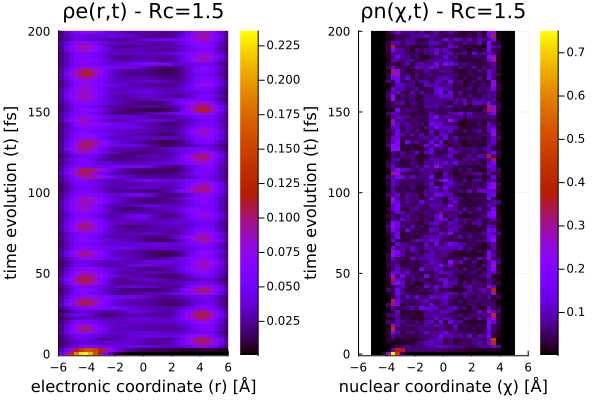

In [100]:
plot1=plot();
plot1=heatmap!(plot1,DOF_r./Angstrom_to_au, time_vec./Femtoseconds_to_au,transpose(electronic_ρ_matrix_χ),
                c = :gnuplot,xlims=(-6,6))
plot1=plot!(plot1,xlabel="electronic coordinate (r) [Å]",ylabel="time evolution (t) [fs]")
plot1=plot!(plot1,title="ρe(r,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

plot2=plot();
plot2=heatmap!(plot2,DOF_χ./Angstrom_to_au, time_vec./Femtoseconds_to_au,transpose(nuclear_ρ_matrix_χ),
                c = :gnuplot,xlims=(-6,6))
plot2=plot!(plot2,xlabel="nuclear coordinate (χ) [Å]",ylabel="time evolution (t) [fs]")
plot2=plot!(plot2,title="ρn(χ,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

display(plot(plot1,plot2,layout=(1,2)))

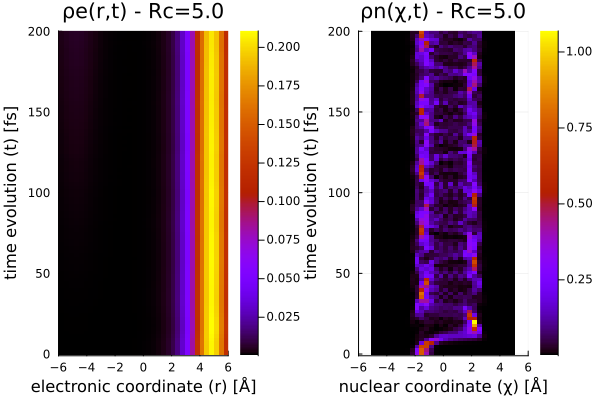

In [205]:
plot1=plot();
plot1=heatmap!(plot1,DOF_r./Angstrom_to_au, time_vec./Femtoseconds_to_au,transpose(electronic_ρ_matrix_χ),
                c = :gnuplot,xlims=(-6,6))
plot1=plot!(plot1,xlabel="electronic coordinate (r) [Å]",ylabel="time evolution (t) [fs]")
plot1=plot!(plot1,title="ρe(r,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

plot2=plot();
plot2=heatmap!(plot2,DOF_χ./Angstrom_to_au, time_vec./Femtoseconds_to_au,transpose(nuclear_ρ_matrix_χ),
                c = :gnuplot,xlims=(-6,6))
plot2=plot!(plot2,xlabel="nuclear coordinate (χ) [Å]",ylabel="time evolution (t) [fs]")
plot2=plot!(plot2,title="ρn(χ,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

display(plot(plot1,plot2,layout=(1,2)))

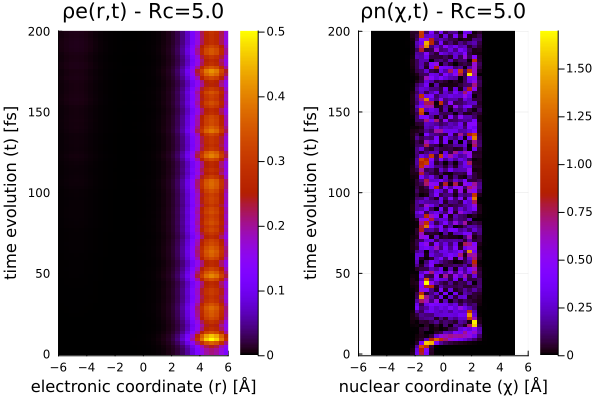

In [204]:
plot1=plot();
plot1=heatmap!(plot1,DOF_r./Angstrom_to_au, time_vec./Femtoseconds_to_au,transpose(electronic_ρ_matrix_χ_v2),
                c = :gnuplot,xlims=(-6,6))
plot1=plot!(plot1,xlabel="electronic coordinate (r) [Å]",ylabel="time evolution (t) [fs]")
plot1=plot!(plot1,title="ρe(r,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

plot2=plot();
plot2=heatmap!(plot2,DOF_χ./Angstrom_to_au, time_vec./Femtoseconds_to_au,transpose(nuclear_ρ_matrix_χ_v2),
                c = :gnuplot,xlims=(-6,6))
plot2=plot!(plot2,xlabel="nuclear coordinate (χ) [Å]",ylabel="time evolution (t) [fs]")
plot2=plot!(plot2,title="ρn(χ,t) - Rc=$(round(Rc/Angstrom_to_au,digits=2))")

display(plot(plot1,plot2,layout=(1,2)))

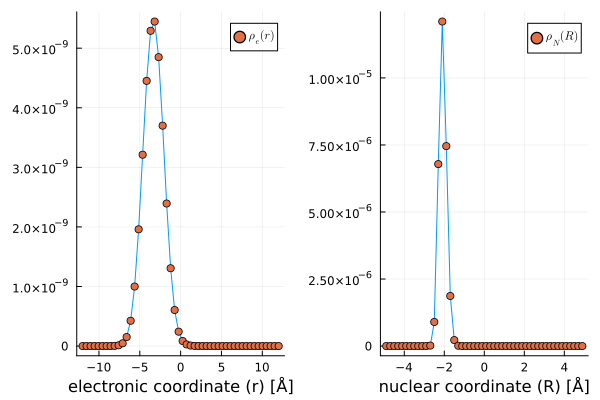

In [35]:
plot1=plot();
plot2=plot!(plot1,DOF_r./Angstrom_to_au,electronic_ρ_matrix[:,end]./γ,label="")
plot2=scatter!(plot1,DOF_r./Angstrom_to_au,electronic_ρ_matrix[:,end]./γ,label="\$ρ_{e}(r)\$")
plot2=plot!(xlabel="electronic coordinate (r) [Å]")

plot3=plot();
plot4=plot!(plot3,DOF_R./(Angstrom_to_au*γ),nuclear_ρ_matrix[:,end],label="")
plot4=scatter!(plot3,DOF_R./(Angstrom_to_au*γ),nuclear_ρ_matrix[:,end],label="\$ρ_{N}(R)\$")
plot4=plot!(xlabel="nuclear coordinate (R) [Å]")

display(plot(plot2,plot4,layout=2))

In [148]:
function densification_xvec(x_vec_old,densification)
    n_old=length(x_vec_old); # number of points elements
    Δx_old=abs(x_vec_old[end]-x_vec_old[1])*(1.0/(n_old-1));
    x_vec_new=[x_vec_old[1]+Δx_old*(1.0/densification)*(i-1)  for i in 1:(n_old-1)*densification+1];
    return x_vec_new;
end

function Trapezoidal_Integration_Method(x_vec,fx_vec)
    dim_x=length(x_vec);

    coef_vec=copy(x_vec);
    coef_vec[1]=1.0;
    coef_vec[2:(dim_x-1)].=2.0;
    coef_vec[end]=1.0;

    function_vec=copy(x_vec);
    function_vec[1]=fx_vec[1];
    function_vec[2:(dim_x-1)].=fx_vec[2:(dim_x-1)];
    function_vec[end]=fx_vec[end];

    Δx=abs(x_vec[2]-x_vec[1]); # válido para cuando Δx es constante

    return 0.5*Δx*(transpose(function_vec)*coef_vec);
end


function Trapezoidal_Integration_Method_v2(x_vec_old,fx_vec_old;TypeInterpolation=AkimaInterpolation,densification=2)

    fx_vec=TypeInterpolation(fx_vec_old,x_vec_old);
    x_vec=densification_xvec(x_vec_old,densification)

    dim_x=length(x_vec);

    coef_vec=copy(x_vec);
    coef_vec[1]=1.0;
    coef_vec[2:(dim_x-1)] .= 2.0;
    coef_vec[end]=1.0;

    function_vec=copy(x_vec);
    function_vec[1]=fx_vec(x_vec[1]);
    function_vec[end]=fx_vec(x_vec[end]);

    for i in 2:(dim_x-1)
        function_vec[i]=fx_vec(x_vec[i]);
    end

    Δx=abs(x_vec[2]-x_vec[1]); # válido para cuando Δx es constante

    return 0.5*Δx*(transpose(function_vec)*coef_vec);

end

function Simpson_Integration_Method(x_vec,fx_vec)
    dim_x=length(x_vec);

    coef_vec=copy(x_vec);
    coef_vec[1]=1.0;
    coef_vec[end]=1.0;

    function_vec=copy(x_vec);
    function_vec[1]=fx_vec[1];
    function_vec[2:(dim_x-1)].=fx_vec[2:(length(x_vec)-1)];
    function_vec[end]=fx_vec[end];

    Δx=abs(x_vec[2]-x_vec[1]); # válido para cuando Δx es constante

    # cantidad de puntos es par => Simpson 1/3
    if (mod(dim_x,2)==0)
        for i in 2:(length(x_vec)-1);
            if (mod(i,2)==0)    # ìndice múltiplo de 2
                coef_vec[i]=4.0;
            else
                coef_vec[i]=2.0;
            end
        end
        factor=(1.0/3.0);
    # cantidad de puntos es par => Simpson 3/8
    else
        for i in 2:(length(x_vec)-1);
            if (mod(i,3)==0)    # ìndice múltiplo de 3
                coef_vec[i]=2.0;
            else
                coef_vec[i]=3.0;
            end
        end
        factor=(3.0/8.0);
    end
    return factor*Δx*(transpose(function_vec)*coef_vec)
end

Simpson_Integration_Method (generic function with 1 method)

## Testing de los integradores

In [67]:
x_start=-10.0;x_end=10.0;
nx=1000;Δx=abs(x_end-x_start)/(nx-1);
x_vec=[x_start+Δx*(i-1) for i in 1:nx];

3.339987702222501e-5
0.0066065411586567115
5.010863658836561e-9


3.3272211023557713e-7


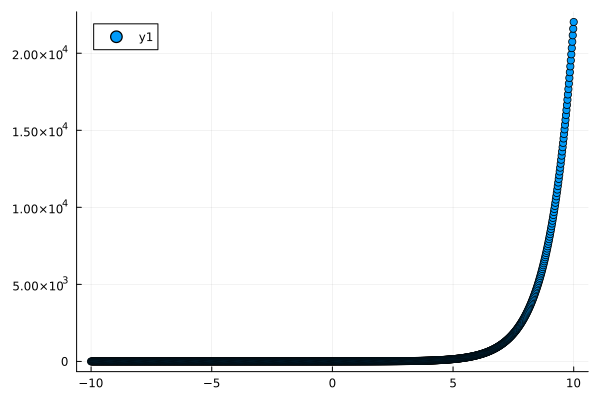

In [69]:
exact_value=2.0*sinh(10)
fx_vec = exp.(x_vec);
println(abs(exact_value-Trapezoidal_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Simpson_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=AkimaInterpolation,densification=200))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=CubicSpline,densification=200))/exact_value)
scatter(x_vec,fx_vec)

0.0005645560198023709
0.004221925185393775


4.1889192171061424e-5
0.00017161151687044795


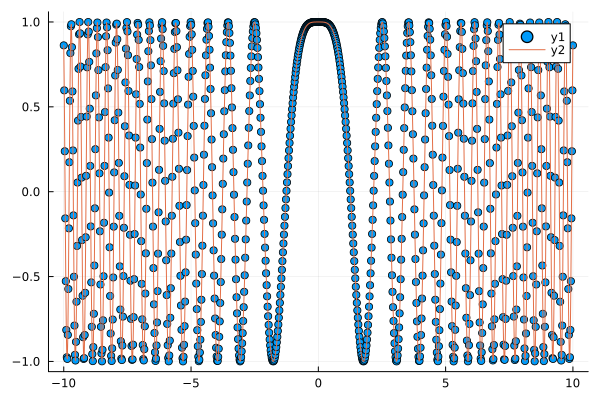

In [71]:
exact_value=1.20225
fx_vec = cos.(x_vec .^ 2);
println(abs(exact_value-Trapezoidal_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Simpson_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=AkimaInterpolation,densification=200))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=CubicSpline,densification=200))/exact_value)
scatter(x_vec,fx_vec)
plot!(x_vec,fx_vec)

1.4210854715202004e-16
5.2159702326264325e-5
3.19317905450589e-12
1.4210854715202004e-16


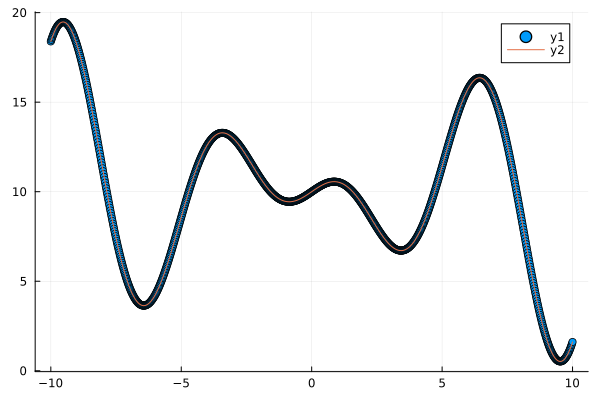

In [72]:
exact_value = 200.0
fx_vec = 10.0 .+ cos.(x_vec) .* x_vec;
println(abs(exact_value-Trapezoidal_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Simpson_Integration_Method(x_vec,fx_vec))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=AkimaInterpolation,densification=200))/exact_value)
println(abs(exact_value-Trapezoidal_Integration_Method_v2(x_vec,fx_vec;TypeInterpolation=CubicSpline,densification=2))/exact_value)
scatter(x_vec,fx_vec)
plot!(x_vec,fx_vec)

## Funciones que computan las entropías reducidas

In [183]:
function integration_argument_diff_shannon_entropy(ρ_x_vector)
    ρlogρ_vec=copy(ρ_x_vector)
    for index in 1:length(ρlogρ_vec)
        ρ_x_vector[index]==0.0 ? ρlogρ_vec[index]=0.0 : ρlogρ_vec[index]=ρ_x_vector[index]*log(ρ_x_vector[index])
    end
    return ρlogρ_vec
end

function Reduced_TimeIndependet_Diff_Shannon_Entropy(x_vec,ρ_x_vector;IntType="trapezoidal")
    if (IntType=="trapezoidal")
        return Trapezoidal_Integration_Method(x_vec,integration_argument_diff_shannon_entropy(ρ_x_vector))
    elseif (IntType=="improved_trapezoidal")
        return Trapezoidal_Integration_Method_v2(x_vec,integration_argument_diff_shannon_entropy(ρ_x_vector);densification=100)
    elseif (IntType=="simpson")
        return Simpson_Integration_Method(x_vec,integration_argument_diff_shannon_entropy(ρ_x_vector))
    end
end

function Reduced_TimeDependent_Diff_Shannon_Entropy(x_vec,ρ_x_matrix;IntType="trapezoidal")
    Sx_vector=Vector{Float64}(undef,length(ρ_x_matrix[1,:]));
    for i in 1:length(Sx_vector)
        Sx_vector[i]=Reduced_TimeIndependet_Diff_Shannon_Entropy(x_vec,ρ_x_matrix[:,i];IntType=IntType)
    end
    return -1.0 .* Sx_vector;
end

Reduced_TimeDependent_Diff_Shannon_Entropy (generic function with 1 method)

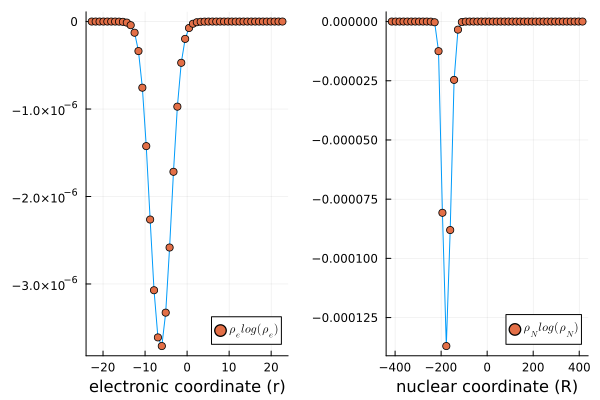

In [39]:
plot1=plot();
plot2=plot!(plot1,DOF_r,integration_argument_diff_shannon_entropy(electronic_ρ_matrix[:,end]),label="")
plot2=scatter!(plot1,DOF_r,integration_argument_diff_shannon_entropy(electronic_ρ_matrix[:,end]),label="\$ρ_{e}log(ρ_{e})\$")
plot2=plot!(xlabel="electronic coordinate (r)")

plot3=plot();
plot4=plot!(plot3,DOF_R,integration_argument_diff_shannon_entropy(nuclear_ρ_matrix[:,end]),label="")
plot4=scatter!(plot3,DOF_R,integration_argument_diff_shannon_entropy(nuclear_ρ_matrix[:,end]),label="\$ρ_{N}log(ρ_{N})\$")
plot4=plot!(xlabel="nuclear coordinate (R)")

display(plot(plot2,plot4,layout=2))

In [94]:
total_S_2D=TimeIndependet_Diff_Shannon_Entropy(𝛹ₓₜ,UH_2D,dΩ_2D)./γ;   # dominio D={r,R}

In [189]:
total_S_2D_χ=TimeIndependet_Diff_Shannon_Entropy(𝛹ₓₜ_χ,UH_2D_χ,dΩ_2D_χ);    # dominio D={r,χ}

In [112]:
# exportamos datos de entropía total

total_S_2D_χ_plus_t=Matrix{Float64}(undef,length(total_S_2D_χ[:,1]),length(total_S_2D_χ[1,:])+1)
total_S_2D_χ_plus_t[:,1]=time_vec[:]
total_S_2D_χ_plus_t[:,2:end]=total_S_2D_χ[:,:]

outfile_1 = path_images*"total_shannon_entropy_vs_time_Rc$(round(Rc/Angstrom_to_au;digits=2)).dat"
rm(outfile_1);

open(outfile_1, "a") do io
    writedlm(io,total_S_2D_χ_plus_t," ")
end

In [206]:
electronic_S_χ=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_r,electronic_ρ_matrix_χ)
nuclear_S_χ=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_χ,nuclear_ρ_matrix_χ)
mutual_info_χ=electronic_S_χ .+ nuclear_S_χ .- total_S_2D_χ;

In [184]:
electronic_S_χ_v2=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_r,electronic_ρ_matrix_χ)
nuclear_S_χ_v2=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_χ,nuclear_ρ_matrix_χ)
mutual_info_χ_v2=electronic_S_χ_v2 .+ nuclear_S_χ_v2 .- total_S_2D_χ;

In [85]:
electronic_S=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_r,electronic_ρ_matrix./γ)
nuclear_S=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_R,nuclear_ρ_matrix)./γ
mutual_info=electronic_S .+ nuclear_S .- total_S_2D;

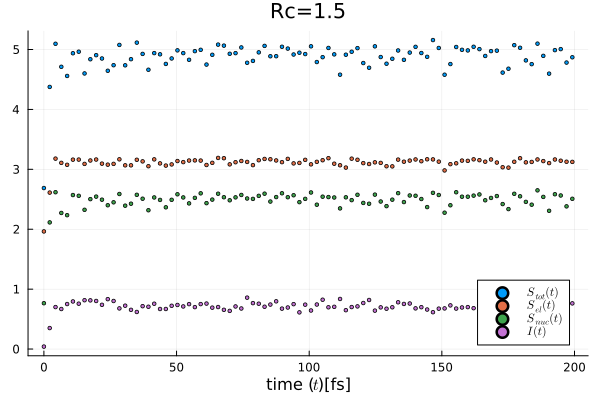

In [104]:
plot1=plot();
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,total_S_2D_χ,label="\$S_{tot}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,electronic_S_χ,label="\$S_{el}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,nuclear_S_χ,label="\$S_{nuc}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,mutual_info_χ,label="\$I(t)\$";markersize=2.0);

plot2=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot(plot2,layout=(1,1),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))");
display(plot3)

### Mostramos los resultados del paper

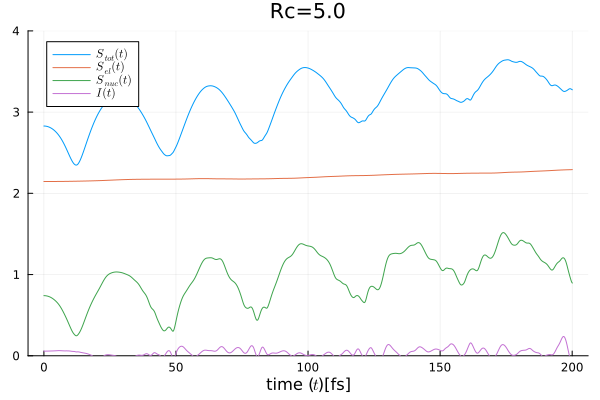

In [96]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,total_S_2D_χ,label="\$S_{tot}(t)\$");
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,electronic_S_χ,label="\$S_{el}(t)\$");
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,nuclear_S_χ,label="\$S_{nuc}(t)\$");
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,mutual_info_χ,label="\$I(t)\$");
plot2=plot!(xlabel="time (\$t\$)[fs]",ylims=(0,4))

plot3=plot(plot2,layout=(1,1),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))");
display(plot3)

In [128]:
using DelimitedFiles;   # to write and read io with specific format

In [129]:
outfile_1 = path_images*"total_shannon_entropy_vs_time_Rc5.0_exact_value.dat"
outfile_2 = path_images*"electronic_shannon_entropy_vs_time_Rc5.0_exact_value.dat"
outfile_3 = path_images*"nuclear_shannon_entropy_vs_time_Rc5.0_exact_value.dat"

total_S_2D_χ_paper = readdlm(outfile_1, Float64);
electronic_S_χ_paper = readdlm(outfile_2, Float64);
nuclear_S_χ_paper = readdlm(outfile_3, Float64);

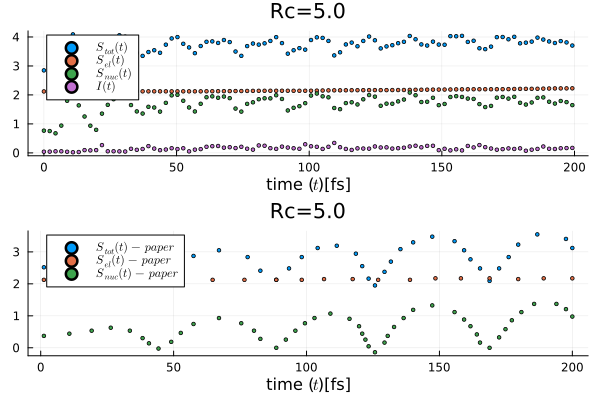

In [207]:
plot1=plot();
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,total_S_2D_χ,label="\$S_{tot}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,electronic_S_χ,label="\$S_{el}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,nuclear_S_χ,label="\$S_{nuc}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,mutual_info_χ,label="\$I(t)\$";markersize=2.0);
plot2=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot();
plot4=scatter!(plot3,total_S_2D_χ_paper[:,1],total_S_2D_χ_paper[:,2],label="\$S_{tot}(t)-paper\$";markersize=2.0);
plot4=scatter!(plot3,electronic_S_χ_paper[:,1],electronic_S_χ_paper[:,2],label="\$S_{el}(t)-paper\$";markersize=2.0);
plot4=scatter!(plot3,nuclear_S_χ_paper[:,1],nuclear_S_χ_paper[:,2],label="\$S_{nuc}(t)-paper\$";markersize=2.0);
plot4=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot(plot2,plot4,layout=(2,1),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))");
display(plot3)

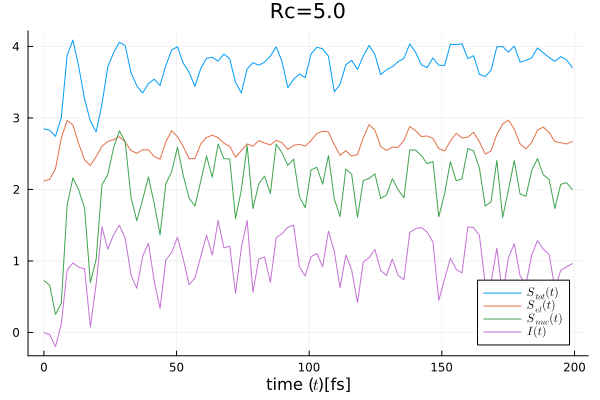

In [190]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,total_S_2D_χ,label="\$S_{tot}(t)\$";markersize=2.0);
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,electronic_S_χ_v2,label="\$S_{el}(t)\$";markersize=2.0);
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,nuclear_S_χ_v2,label="\$S_{nuc}(t)\$";markersize=2.0);
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,mutual_info_χ_v2,label="\$I(t)\$";markersize=2.0);
plot2=plot!(xlabel="time (\$t\$)[fs]")

plot3=plot(plot2,layout=(1,1),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))");
display(plot3)

In [87]:
electronic_S_simpson=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_r,electronic_ρ_matrix./γ;IntType="simpson")
nuclear_S_simpson=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_R,nuclear_ρ_matrix;IntType="simpson")./γ
mutual_info_simpson=electronic_S_simpson .+ nuclear_S_simpson .- total_S_2D;

Usamos un paquete de interpolación para poder calcular la integración dentro de Gridap

In [196]:
function InterpolationFunction(x,x_component,fx_vector,x_vector)
    f=InterpolationFunction_v2(fx_vector,x_vector)
    return f(x[x_component])
end

function InterpolationFunction_v2(fx_vector,x_vector;TypeInterpolation=AkimaInterpolation)
    f = TypeInterpolation(fx_vector,x_vector)
    return f
end

function ReducedEntropy(x_component,ρx_matrix,x_vector,Ω,dΩ;TypeAproxDeltaFunction="StepFunction")

    (x_component==1) ? (complement_x_component=2) : (complement_x_component=1)

    Sx_vector=Vector{Float64}(undef,length(ρx_matrix[1,:]));

    N₁=abs(x_vector[end]-x_vector[1]);

    if (TypeAproxDeltaFunction=="StepFunction")
        Δx=abs(x_vector[2]-x_vector[1])
    end

    for time_index in 1:length(ρx_matrix[1,:])
        fx_vector=integration_argument_diff_shannon_entropy(ρx_matrix[:,time_index]);
        fx_InterpolationGridap=CellField(x->InterpolationFunction(x,x_component,fx_vector,x_vector),Ω);
        if (TypeAproxDeltaFunction=="StepFunction")
            params=(0.0,1.0,complement_x_component,Δx)
        elseif (TypeAproxDeltaFunction=="BumpFunction")
            params=(0.0,1.0,complement_x_component)
        end
        δKroneckerGridap=CellField(x->AproxDiracDeltaFunction(x,params;TypeFunction=TypeAproxDeltaFunction),Ω);
        δnorm=sum(integrate(δKroneckerGridap,dΩ));
        if (TypeAproxDeltaFunction=="StepFunction")
            params=(0.0,δnorm/N₁,complement_x_component,Δx)
        elseif (TypeAproxDeltaFunction=="BumpFunction")
            params=(0.0,δnorm/N₁,complement_x_component)
        end
        δKroneckerGridap=CellField(x->AproxDiracDeltaFunction(x,params;TypeFunction=TypeAproxDeltaFunction),Ω);

        Sx_vector[time_index]=-sum(∫(fx_InterpolationGridap*δKroneckerGridap)*dΩ)
    end

    return Sx_vector;
    
end

ReducedEntropy (generic function with 1 method)

In [89]:
electronic_S_interpolation=ReducedEntropy(1,electronic_ρ_matrix./γ,DOF_r,Ω_2D,dΩ_2D);
nuclear_S_interpolation=ReducedEntropy(2,nuclear_ρ_matrix,DOF_R,Ω_2D,dΩ_2D)./γ;
mutual_info_interpolation=electronic_S_interpolation.+nuclear_S_interpolation.-total_S_2D;

In [208]:
electronic_S_interpolation_χ=ReducedEntropy(1,electronic_ρ_matrix_χ,DOF_r,Ω_2D_χ,dΩ_2D_χ;TypeAproxDeltaFunction="StepFunction");
nuclear_S_interpolation_χ=ReducedEntropy(2,nuclear_ρ_matrix_χ,DOF_χ,Ω_2D_χ,dΩ_2D_χ;TypeAproxDeltaFunction="StepFunction");
mutual_info_interpolation_χ=electronic_S_interpolation_χ.+nuclear_S_interpolation_χ.-total_S_2D_χ;

In [197]:
electronic_S_interpolation_χ_v2=ReducedEntropy(1,electronic_ρ_matrix_χ_v2,DOF_r,Ω_2D_χ,dΩ_2D_χ;TypeAproxDeltaFunction="StepFunction");
nuclear_S_interpolation_χ_v2=ReducedEntropy(2,nuclear_ρ_matrix_χ_v2,DOF_χ,Ω_2D_χ,dΩ_2D_χ;TypeAproxDeltaFunction="StepFunction");
mutual_info_interpolation_χ_v2=electronic_S_interpolation_χ_v2.+nuclear_S_interpolation_χ_v2.-total_S_2D_χ;

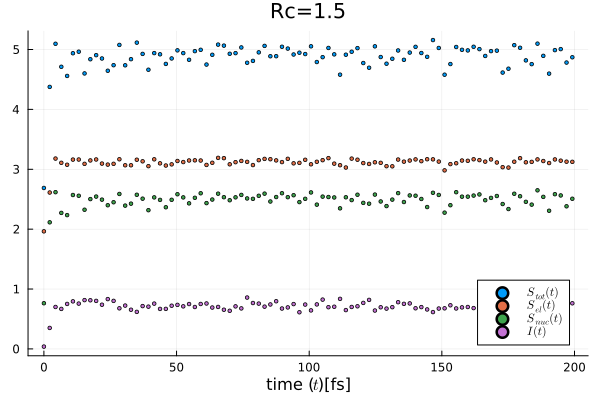

In [91]:
plot1=plot();
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,total_S_2D_χ,label="\$S_{tot}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,electronic_S_interpolation_χ,label="\$S_{el}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,nuclear_S_interpolation_χ,label="\$S_{nuc}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,mutual_info_interpolation_χ,label="\$I(t)\$";markersize=2.0);
plot2=plot!(xlabel="time (\$t\$)[fs]")

display(plot(plot2,layout=(1,1),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))"))

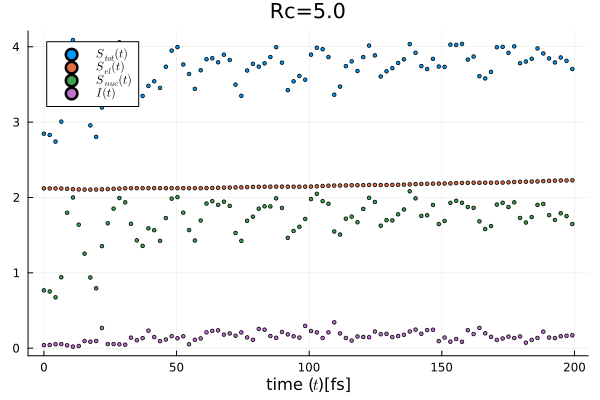

In [209]:
plot1=plot();
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,total_S_2D_χ,label="\$S_{tot}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,electronic_S_interpolation_χ,label="\$S_{el}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,nuclear_S_interpolation_χ,label="\$S_{nuc}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,mutual_info_interpolation_χ,label="\$I(t)\$";markersize=2.0);
plot2=scatter!(xlabel="time (\$t\$)[fs]")

display(plot(plot2,layout=(1,1),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))"))

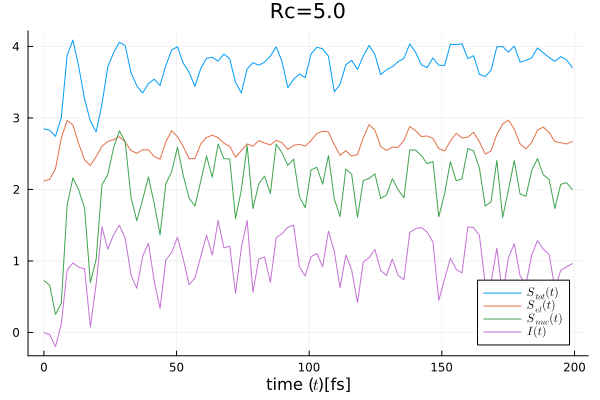

In [198]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,total_S_2D_χ,label="\$S_{tot}(t)\$";markersize=2.0);
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,electronic_S_interpolation_χ_v2,label="\$S_{el}(t)\$";markersize=2.0);
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,nuclear_S_interpolation_χ_v2,label="\$S_{nuc}(t)\$";markersize=2.0);
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,mutual_info_interpolation_χ_v2,label="\$I(t)\$";markersize=2.0);
plot2=scatter!(xlabel="time (\$t\$)[fs]")

display(plot(plot2,layout=(1,1),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))"))

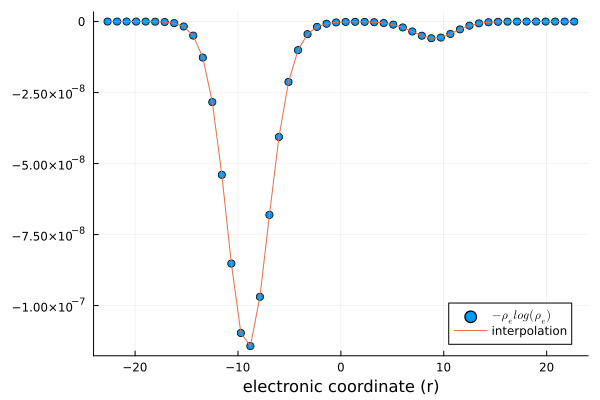

In [91]:
fx_vector=(electronic_ρ_matrix[:,end]./γ) .* log.(electronic_ρ_matrix[:,end]./γ);

plot1=plot();
plot2=scatter!(plot1,DOF_r,integration_argument_diff_shannon_entropy(electronic_ρ_matrix[:,end]./γ),label="\$-ρ_{e}log(ρ_{e})\$")
plot2=plot!(plot1,DOF_r,InterpolationFunction_v2(fx_vector,DOF_r).(DOF_r),label="interpolation")
plot2=plot!(xlabel="electronic coordinate (r)")

### Calculamos valores de expectación de la posición

In [75]:
function xfunction(x,x_component)
    return x[x_component]
end

function x²function(x,x_component)
    return pow(x[x_component],2)
end

function xvariancefunction(x,x₀,x_component)
    return pow(x[x_component]-x₀,2)
end

function position_expectation_value(𝛹ₓₜ,Ω,dΩ,TrialSpace,x_component)
    xGridap=CellField(x->xfunction(x,x_component),Ω);
    x_ExpValue_vector=zeros(Float64,length(𝛹ₓₜ));

    for time_index in 1:length(𝛹ₓₜ)
        𝛹ₓₜⁱ=interpolate_everywhere(𝛹ₓₜ[time_index],TrialSpace)
        # ojo! tomamos la parte real porque se trata de la coord. espacial, pero puede ser complejo
        x_ExpValue_vector[time_index]=real(sum(∫((𝛹ₓₜⁱ)'*xGridap*𝛹ₓₜⁱ)*dΩ))
    end

    return x_ExpValue_vector;
end

function position_variance(𝛹ₓₜ,Ω,dΩ,TrialSpace,x_component)
    x_variance_vector=zeros(Float64,length(𝛹ₓₜ));
    x₀_vector=position_expectation_value(𝛹ₓₜ,Ω,dΩ,TrialSpace,x_component);

    for time_index in 1:length(𝛹ₓₜ)
        IntegralFactorGridap=CellField(x->xvariancefunction(x,x₀_vector[time_index],x_component),Ω);
        𝛹ₓₜⁱ=interpolate_everywhere(𝛹ₓₜ[time_index],TrialSpace)
        # ojo! tomamos la parte real porque se trata de la coord. espacial, pero puede ser complejo
        x_variance_vector[time_index]=sqrt(real(sum(∫(conj(𝛹ₓₜⁱ)*IntegralFactorGridap*𝛹ₓₜⁱ)*dΩ)))
    end

    return x_variance_vector;
end

function position²_expectation_value(𝛹ₓₜ,Ω,dΩ,TrialSpace,x_component)
    x²Gridap=CellField(x->x²function(x,x_component),Ω);
    x²_ExpValue_vector=zeros(Float64,length(𝛹ₓₜ));

    for time_index in 1:length(𝛹ₓₜ)
        𝛹ₓₜⁱ=interpolate_everywhere(𝛹ₓₜ[time_index],TrialSpace)
        # ojo! tomamos la parte real porque se trata de la coord. espacial, pero puede ser complejo
        x²_ExpValue_vector[time_index]=real(sum(∫((𝛹ₓₜⁱ)'*x²Gridap*𝛹ₓₜⁱ)*dΩ))
    end

    return x²_ExpValue_vector;
end

position²_expectation_value (generic function with 1 method)

In [109]:
# dominio D={r,R}
r_ExpValue=position_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UH_2D,1);
R_ExpValue=position_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UH_2D,2);

In [140]:
# dominio D={r,χ}
r_ExpValue_χ=position_expectation_value(𝛹ₓₜ_χ,Ω_2D_χ,dΩ_2D_χ,UH_2D_χ,1);
χ_ExpValue=position_expectation_value(𝛹ₓₜ_χ,Ω_2D_χ,dΩ_2D_χ,UH_2D_χ,2);

Esta opción no nos dá bien, es más, el resultado es igual al valor de expectación de la posición lo cual claramente no puede ser

In [134]:
r_variance=position_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UH_2D,1);
R_variance=position_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UH_2D,2);

Por ello probamos calcular la varianza de la siguiente manera

In [110]:
# dominio D={r,R}

r²_ExpValue=position²_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UH_2D,1);
R²_ExpValue=position²_expectation_value(𝛹ₓₜ,Ω_2D,dΩ_2D,UH_2D,2);

r_variance_v2=sqrt.(r²_ExpValue.-(r_ExpValue.*r_ExpValue));
R_variance_v2=sqrt.(R²_ExpValue.-(R_ExpValue.*R_ExpValue));

In [141]:
# dominio D={r,χ}

r²_ExpValue_χ=position²_expectation_value(𝛹ₓₜ_χ,Ω_2D_χ,dΩ_2D_χ,UH_2D_χ,1);
χ²_ExpValue=position²_expectation_value(𝛹ₓₜ_χ,Ω_2D_χ,dΩ_2D_χ,UH_2D_χ,2);

r_variance_v2_χ=sqrt.(r²_ExpValue_χ.-(r_ExpValue_χ.*r_ExpValue_χ));
χ_variance_v2=sqrt.(χ²_ExpValue.-(χ_ExpValue.*χ_ExpValue));

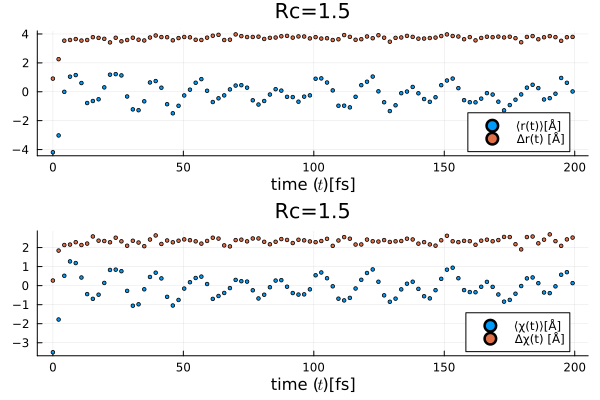

In [93]:
plot1=plot();
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,r_ExpValue_χ./Angstrom_to_au,label="⟨r(t)⟩[Å]";markersize=2.0)
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,r_variance_v2_χ./Angstrom_to_au,label="Δr(t) [Å]";markersize=2.0)
plot2=plot!(xlabel="time (\$t\$)[fs]",title="Rc=$(round(Rc/Angstrom_to_au,digits=2))")

plot3=plot();
plot4=scatter!(plot3,time_vec./Femtoseconds_to_au,χ_ExpValue./Angstrom_to_au,label="⟨χ(t)⟩[Å]";markersize=2.0)
plot4=scatter!(plot3,time_vec./Femtoseconds_to_au,χ_variance_v2./Angstrom_to_au,label="Δχ(t) [Å]";markersize=2.0)
plot4=plot!(xlabel="time (\$t\$)[fs]",title="Rc=$(round(Rc/Angstrom_to_au,digits=2))")

display(plot(plot2,plot4,layout=(2,1)))

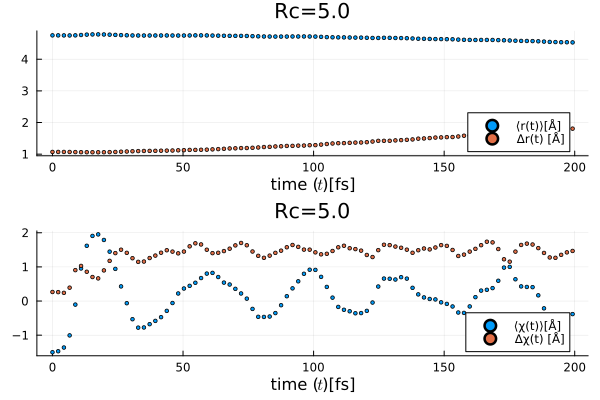

In [142]:
plot1=plot();
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,r_ExpValue_χ./Angstrom_to_au,label="⟨r(t)⟩[Å]";markersize=2.0)
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,r_variance_v2_χ./Angstrom_to_au,label="Δr(t) [Å]";markersize=2.0)
plot2=scatter!(xlabel="time (\$t\$)[fs]",title="Rc=$(round(Rc/Angstrom_to_au,digits=2))";markersize=2.0)

plot3=plot();
plot4=scatter!(plot3,time_vec./Femtoseconds_to_au,χ_ExpValue./Angstrom_to_au,label="⟨χ(t)⟩[Å]";markersize=2.0)
plot4=scatter!(plot3,time_vec./Femtoseconds_to_au,χ_variance_v2./Angstrom_to_au,label="Δχ(t) [Å]";markersize=2.0)
plot4=scatter!(xlabel="time (\$t\$)[fs]",title="Rc=$(round(Rc/Angstrom_to_au,digits=2))")

display(plot(plot2,plot4,layout=(2,1)))

## Probamos otro método para calcular entropías, que incluye crear grillas nuevas

In [199]:
function ReducedEntropy_Grid1D(ρx_matrix,x_vector,Ω,dΩ)

    Sx_vector=Vector{Float64}(undef,length(ρx_matrix[1,:]));

    for time_index in 1:length(ρx_matrix[1,:])
        fx_vector=integration_argument_diff_shannon_entropy(ρx_matrix[:,time_index]);
        fx_InterpolationGridap=CellField(x->InterpolationFunction(x,1,fx_vector,x_vector),Ω);

        Sx_vector[time_index]=-sum(integrate(fx_InterpolationGridap,dΩ))
    end

    return Sx_vector;
end

ReducedEntropy_Grid1D (generic function with 1 method)

In [ ]:
electronic_S_interpolation_1D=ReducedEntropy_Grid1D(electronic_ρ_matrix./γ,DOF_r_1D,Ω_1D_r,dΩ_1D_r);
nuclear_S_interpolation_1D=ReducedEntropy_Grid1D(nuclear_ρ_matrix,DOF_χ_1D,Ω_1D_χ,dΩ_1D_χ);
mutual_info_1D=electronic_S_interpolation_1D .+ nuclear_S_interpolation_1D .- total_S_2D;

In [210]:
electronic_S_interpolation_1D_χ=ReducedEntropy_Grid1D(electronic_ρ_matrix_χ,DOF_r_1D,Ω_1D_r,dΩ_1D_r);
nuclear_S_interpolation_1D_χ=ReducedEntropy_Grid1D(nuclear_ρ_matrix_χ,DOF_χ_1D,Ω_1D_χ,dΩ_1D_χ);
mutual_info_1D_χ=electronic_S_interpolation_1D_χ .+ nuclear_S_interpolation_1D_χ .- total_S_2D_χ;

In [201]:
electronic_S_interpolation_1D_χ_v2=ReducedEntropy_Grid1D(electronic_ρ_matrix_χ_v2,DOF_r_1D,Ω_1D_r,dΩ_1D_r);
nuclear_S_interpolation_1D_χ_v2=ReducedEntropy_Grid1D(nuclear_ρ_matrix_χ_v2,DOF_χ_1D,Ω_1D_χ,dΩ_1D_χ);
mutual_info_1D_χ_v2=electronic_S_interpolation_1D_χ_v2 .+ nuclear_S_interpolation_1D_χ_v2 .- total_S_2D_χ;

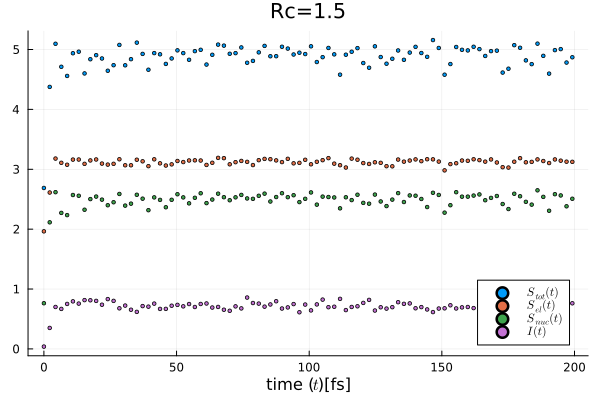

In [96]:
plot1=plot();
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,total_S_2D_χ,label="\$S_{tot}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,electronic_S_interpolation_1D_χ,label="\$S_{el}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,nuclear_S_interpolation_1D_χ,label="\$S_{nuc}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,mutual_info_1D_χ,label="\$I(t)\$";markersize=2.0);
plot2=plot!(xlabel="time (\$t\$)[fs]")

display(plot(plot2,layout=(1,1),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))"))

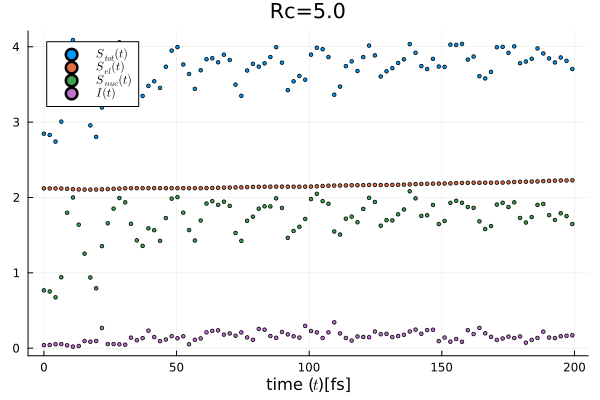

In [211]:
plot1=plot();
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,total_S_2D_χ,label="\$S_{tot}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,electronic_S_interpolation_1D_χ,label="\$S_{el}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,nuclear_S_interpolation_1D_χ,label="\$S_{nuc}(t)\$";markersize=2.0);
plot2=scatter!(plot1,time_vec./Femtoseconds_to_au,mutual_info_1D_χ,label="\$I(t)\$";markersize=2.0);
plot2=plot!(xlabel="time (\$t\$)[fs]")

display(plot(plot2,layout=(1,1),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))"))

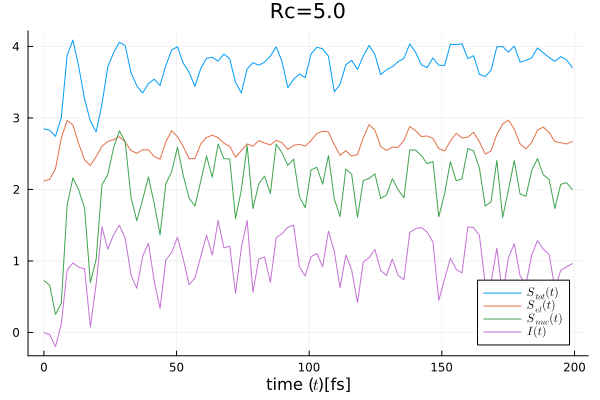

In [202]:
plot1=plot();
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,total_S_2D_χ,label="\$S_{tot}(t)\$";markersize=2.0);
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,electronic_S_interpolation_1D_χ_v2,label="\$S_{el}(t)\$";markersize=2.0);
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,nuclear_S_interpolation_1D_χ_v2,label="\$S_{nuc}(t)\$";markersize=2.0);
plot2=plot!(plot1,time_vec./Femtoseconds_to_au,mutual_info_1D_χ_v2,label="\$I(t)\$";markersize=2.0);
plot2=plot!(xlabel="time (\$t\$)[fs]")

display(plot(plot2,layout=(1,1),title="Rc=$(round(Rc/Angstrom_to_au,digits=2))"))